# Node-GAM 

This is a demonstration of using Node-GAM: an improved inherently interpretable Neural Additive Model.


This is the  [Github repo](https://github.com/zzzace2000/nodegam?tab=readme-ov-file) for NodeGAM.

**Reference:**
"NODE-GAM: Neural Generalized Additive Model for Interpretable Deep Learning",
Chang, CH,  Caruana, R. and Goldenberg, A.,ICLR 2022


## **1.Import packages**

In [149]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nodegam.sklearn import NodeGAMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import pickle






## **2. Load dataset**


For this example, we shall use the UCI Credit Score dataset to illustrate a classification example using NodeGAM.

In [150]:

# Load the dataset
dataset_path = 'credit_card_defaulters.xls'
df = pd.read_excel(dataset_path, header=1)

# Preprocess: drop ID and rename target column
df.drop('ID', axis=1, inplace=True)
df.rename(columns={'default payment next month': 'default_payment_next_month'}, inplace=True)

# Separate target and features
y = df['default_payment_next_month']
X = df.drop('default_payment_next_month', axis=1)

# Define categorical and numerical features
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                      'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
                      'PAY_AMT5', 'PAY_AMT6']

# Split the data into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Process numerical features
X_train_num = X_train[numerical_features].astype('float32')
X_test_num = X_test[numerical_features].astype('float32')

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Save the scaler for future use
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# Process categorical features with one-hot encoding on the training set
X_train_cat = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_test_cat = pd.get_dummies(X_test[categorical_features], drop_first=True)

# Align the test set to have the same dummy columns as the training set
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Merge numerical and categorical features
X_train_processed = np.hstack((X_train_num_scaled, X_train_cat.values))
X_test_processed = np.hstack((X_test_num_scaled, X_test_cat.values))

# Create a list of all feature names (numerical + categorical)
all_features = numerical_features + list(X_train_cat.columns)

# Convert processed training data into a DataFrame for inspection
X_train_df = pd.DataFrame(X_train_processed, columns=all_features)
print(X_train_df.head())
   


   LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0  -0.672359 -1.244658   0.329670   0.400979   0.455707   0.479450  -0.008367   
1  -1.057768 -0.811522  -0.295445  -0.273649  -0.254132  -0.277182  -0.299323   
2   0.098459  0.921024  -0.408879  -0.689698  -0.662788  -0.671371  -0.548685   
3  -0.826523 -1.136374   0.107788   0.060915  -0.118736  -0.052671  -0.008763   
4  -0.286950 -1.136374   0.826432   0.894408   0.981423   1.167654   1.330983   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  ...  PAY_AMT6  SEX  EDUCATION  MARRIAGE  \
0   0.011698 -0.126892 -0.039537  ... -0.245240  2.0        2.0       2.0   
1  -0.653898 -0.038915 -0.194250  ... -0.295532  1.0        2.0       2.0   
2  -0.479473 -0.331937 -0.210475  ... -0.285107  2.0        5.0       1.0   
3   0.006350 -0.213815 -0.167236  ... -0.180973  1.0        1.0       2.0   
4   1.436224 -0.091947 -0.072522  ...  0.317359  2.0        2.0       2.0   

   PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  
0   

## **3. Dataloader and Model instantiation**




In [ ]:
import pandas as pd
import numpy as np
from nodegam.sklearn import NodeGAMClassifier

# Subclass pandas DataFrame to always use positional indexing for integer keys.
# This is necessary because NodeGAMClassifier uses positional indexing internally.

class RangeIndexDataFrame(pd.DataFrame):
    @property
    def _constructor(self):
        return RangeIndexDataFrame

    def __getitem__(self, key):
        if isinstance(key, (int, list, np.ndarray)):
            return self.iloc[key]
        return super().__getitem__(key)

# Subclass pandas Series similarly.
class RangeIndexSeries(pd.Series):
    @property
    def _constructor(self):
        return RangeIndexSeries

    def __getitem__(self, key):
        if isinstance(key, (int, list, np.ndarray)):
            return self.iloc[key]
        return super().__getitem__(key)

# After preprocessing, suppose you have:
# - X_train_processed: your processed NumPy array of features
# - all_features: list of feature names for X_train_processed
# - y_train: your target Series, with its index reset

# Wrap your training data in the custom classes:
X_train_df = RangeIndexDataFrame(X_train_processed, columns=all_features)
y_train_series = RangeIndexSeries(y_train.reset_index(drop=True))

# Ensure the DataFrame's index is a simple RangeIndex
X_train_df.reset_index(drop=True, inplace=True)

# Create and fit your model using the wrapped objects.
model = NodeGAMClassifier(in_features=X_train_df.shape[1])
model.fit(X_train_df, y_train_series)


Steps	Train Err	Val Metric (ce_loss)
100	0.4544	0.4738
200	0.4723	0.4479
300	0.4565	0.4423
400	0.4178	0.4329
500	0.4319	0.429
600	0.4318	0.4236
700	0.4283	0.4231
800	0.4284	0.4128
900	0.431	0.411
1000	0.4268	0.4115
1100	0.4579	0.4109
1200	0.4447	0.4112
1300	0.4294	0.4115
1400	0.4296	0.4105
1500	0.418	0.4109
1600	0.4073	0.4103
1700	0.4209	0.4093
1800	0.4343	0.4096
1900	0.4376	0.41
2000	0.4269	0.4107
2100	0.4254	0.4106
2200	0.427	0.4099
2300	0.4174	0.41
LR: 1.00e-02 -> 2.00e-03
2400	0.4151	0.4086
2500	0.4301	0.4075
2600	0.4065	0.407
2700	0.4249	0.4069
2800	0.4267	0.4071
2900	0.4182	0.4072
3000	0.4184	0.4075
LR: 2.00e-03 -> 4.00e-04
3100	0.422	0.4075
3200	0.4079	0.4077
3300	0.4185	0.4076
LR: 4.00e-04 -> 8.00e-05
3400	0.4384	0.4076
3500	0.4252	0.4075
3600	0.4177	0.4075
LR: 8.00e-05 -> 1.60e-05
3700	0.4155	0.4075
3800	0.4196	0.4075
3900	0.4519	0.4075
LR: 1.60e-05 -> 3.20e-06
4000	0.4176	0.4076
4100	0.4048	0.4075
4200	0.4198	0.4075
LR: 3.20e-06 -> 1.00e-06
4300	0.4159	0.4075
4400	0.4068	0.40

{'train_losses': [0.7426252365112305,
  0.5865795016288757,
  0.5856227874755859,
  0.631313681602478,
  0.5603114366531372,
  0.6284440159797668,
  0.5152299404144287,
  0.5487322807312012,
  0.5771846771240234,
  0.524392306804657,
  0.5281302332878113,
  0.5715335011482239,
  0.5318241715431213,
  0.5297111868858337,
  0.5346307754516602,
  0.5084332227706909,
  0.5229049324989319,
  0.5370391607284546,
  0.571907103061676,
  0.5333969593048096,
  0.5290918350219727,
  0.5392718315124512,
  0.4888865649700165,
  0.5333610773086548,
  0.5051112174987793,
  0.5935626029968262,
  0.5083339810371399,
  0.5097293853759766,
  0.5078933238983154,
  0.5086574554443359,
  0.4741683006286621,
  0.5324376821517944,
  0.5126656889915466,
  0.5138717889785767,
  0.49575474858283997,
  0.48290741443634033,
  0.49851852655410767,
  0.505870521068573,
  0.49356549978256226,
  0.5022863745689392,
  0.47783154249191284,
  0.5218725204467773,
  0.49660027027130127,
  0.5108926296234131,
  0.4830184280

Accuracy: 0.8173333333333334


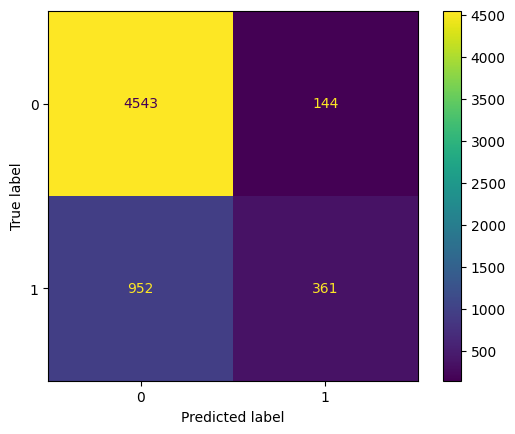

In [152]:


# Wrap your test data in the custom classes:
X_test_df = RangeIndexDataFrame(X_test_processed, columns=all_features)
y_test_series = RangeIndexSeries(y_test.reset_index(drop=True))

# Ensure the DataFrame's index is a simple RangeIndex
X_test_df.reset_index(drop=True, inplace=True)

# Get the continuous predictions
y_pred_continuous = model.predict(X_test_df)

# Convert continuous predictions to binary class labels
y_pred = (y_pred_continuous > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

ConfusionMatrixDisplay.from_predictions(y_test_series, y_pred)
plt.show()


bin features BILL_AMT1 with uniq val 18698 to only 256
bin features BILL_AMT2 with uniq val 18360 to only 256
bin features BILL_AMT3 with uniq val 18145 to only 256
bin features BILL_AMT4 with uniq val 17745 to only 256
bin features BILL_AMT5 with uniq val 17341 to only 256
bin features BILL_AMT6 with uniq val 17013 to only 256
bin features PAY_AMT1 with uniq val 6917 to only 256
bin features PAY_AMT2 with uniq val 6888 to only 256
bin features PAY_AMT3 with uniq val 6533 to only 256
bin features PAY_AMT4 with uniq val 6055 to only 256
bin features PAY_AMT5 with uniq val 6014 to only 256
bin features PAY_AMT6 with uniq val 5999 to only 256
Finish "Run values through model" in 278ms


100%|██████████| 181/181 [00:00<00:00, 335.01it/s]


Finish "Extract values" in 572ms
Finish "Purify interactions to main effects" in 837ms
Finish "Center main effects" in 2ms


100%|██████████| 190/190 [00:02<00:00, 86.62it/s] 

Finish "Construct table" in 2.2s
   feat_name feat_idx                                                  x  \
0     offset       -1                                               None   
1  LIMIT_BAL        0  [-1.211931824684143, -1.1656827926635742, -1.1...   
2        AGE        1  [-1.5695101022720337, -1.461225986480713, -1.3...   
3  BILL_AMT1        2  [-2.949720621109009, -0.7037874460220337, -0.6...   
4  BILL_AMT2        3  [-1.6735533475875854, -0.7041157484054565, -0....   

                                                   y  importance  \
0                              [-1.5629100609683197]   -1.000000   
1  [0.5056928331696928, 0.576186376684312, 0.4228...    0.251433   
2  [-0.24889048075534942, -0.16129912547221859, -...    0.048579   
3  [-0.36246886525686195, -0.030612687854249754, ...    0.135716   
4  [0.13497020403560808, 0.09323677200724467, 0.0...    0.070466   

                                              counts  
0                                             

(<Figure size 2200x300 with 4 Axes>,
 array([[<Axes: title={'center': 'PAY_0 (Imp=0.526)'}>,
         <Axes: title={'center': 'LIMIT_BAL (Imp=0.251)'}>,
         <Axes: title={'center': 'BILL_AMT1 (Imp=0.136)'}>,
         <Axes: title={'center': 'PAY_3 (Imp=0.125)'}>]], dtype=object))

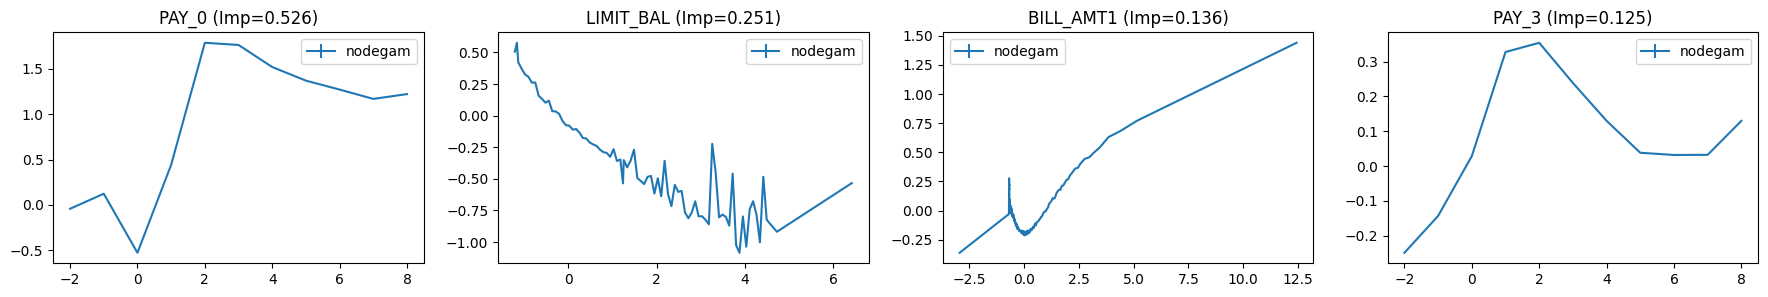

In [153]:
# Get the GAM dataframe
gam_df = model.get_GAM_df(X_train_df)
print(gam_df.head())


# Sort the GAM DataFrame by importance and select the top 4 features
top_features = gam_df.sort_values(by='importance', ascending=False).head(4)

# Visualize the top 8 features
vis_GAM_effects({
    'nodegam': top_features,
})


## Model Interpretation

1. **PAY_0 (Imp = 0.487)**
- Most important feature.
- PAY_0 represents the repayment status for the most recent month.
- The shape plot shows a steep increase in predicted default risk when PAY_0 moves from 0 (paid on time) to higher values (delays in months).
- The jump between 0 and 1 suggests that even being one month late significantly increases default risk.
- The risk keeps increasing with more severe delays (e.g., 3+ months late).
  
2. **LIMIT_BAL (Imp = 0.256)**
- A negative slope indicates that higher credit limits are associated with lower default risk.
- The effect stabilizes at very high limits, suggesting diminishing impact.
- The fluctuations may be due to irregularities in certain credit limit brackets.

3. **BILL_AMT1 (Imp = 0.175)**
- First bill amount (most recent month’s statement).
- The shape plot shows a strong positive correlation between high bill amounts and increased risk.
- This suggests that having large outstanding balances is linked to a higher likelihood of default.
  

4. **PAY_AMT3 (Imp = 0.139)**
- Repayment status from 3 months ago.
- A sharp negative slope indicates that higher payments strongly reduce risk.
- The steep drop-off suggests that even modest payments help lower risk significantly.
- Similar to PAY_0, a delayed payment (values > 0) increases default risk.
- The peak around 3 months late suggests that this is a critical tipping point in risk assessment.


## Comparison with EBMs


The nodegam package conveniently has functionality to compare multiple models such as conventional GAM, EBM and XGBoost.
In the following block, we compare the shape function plots or partial dependence plot between EBM and Node-GAM:




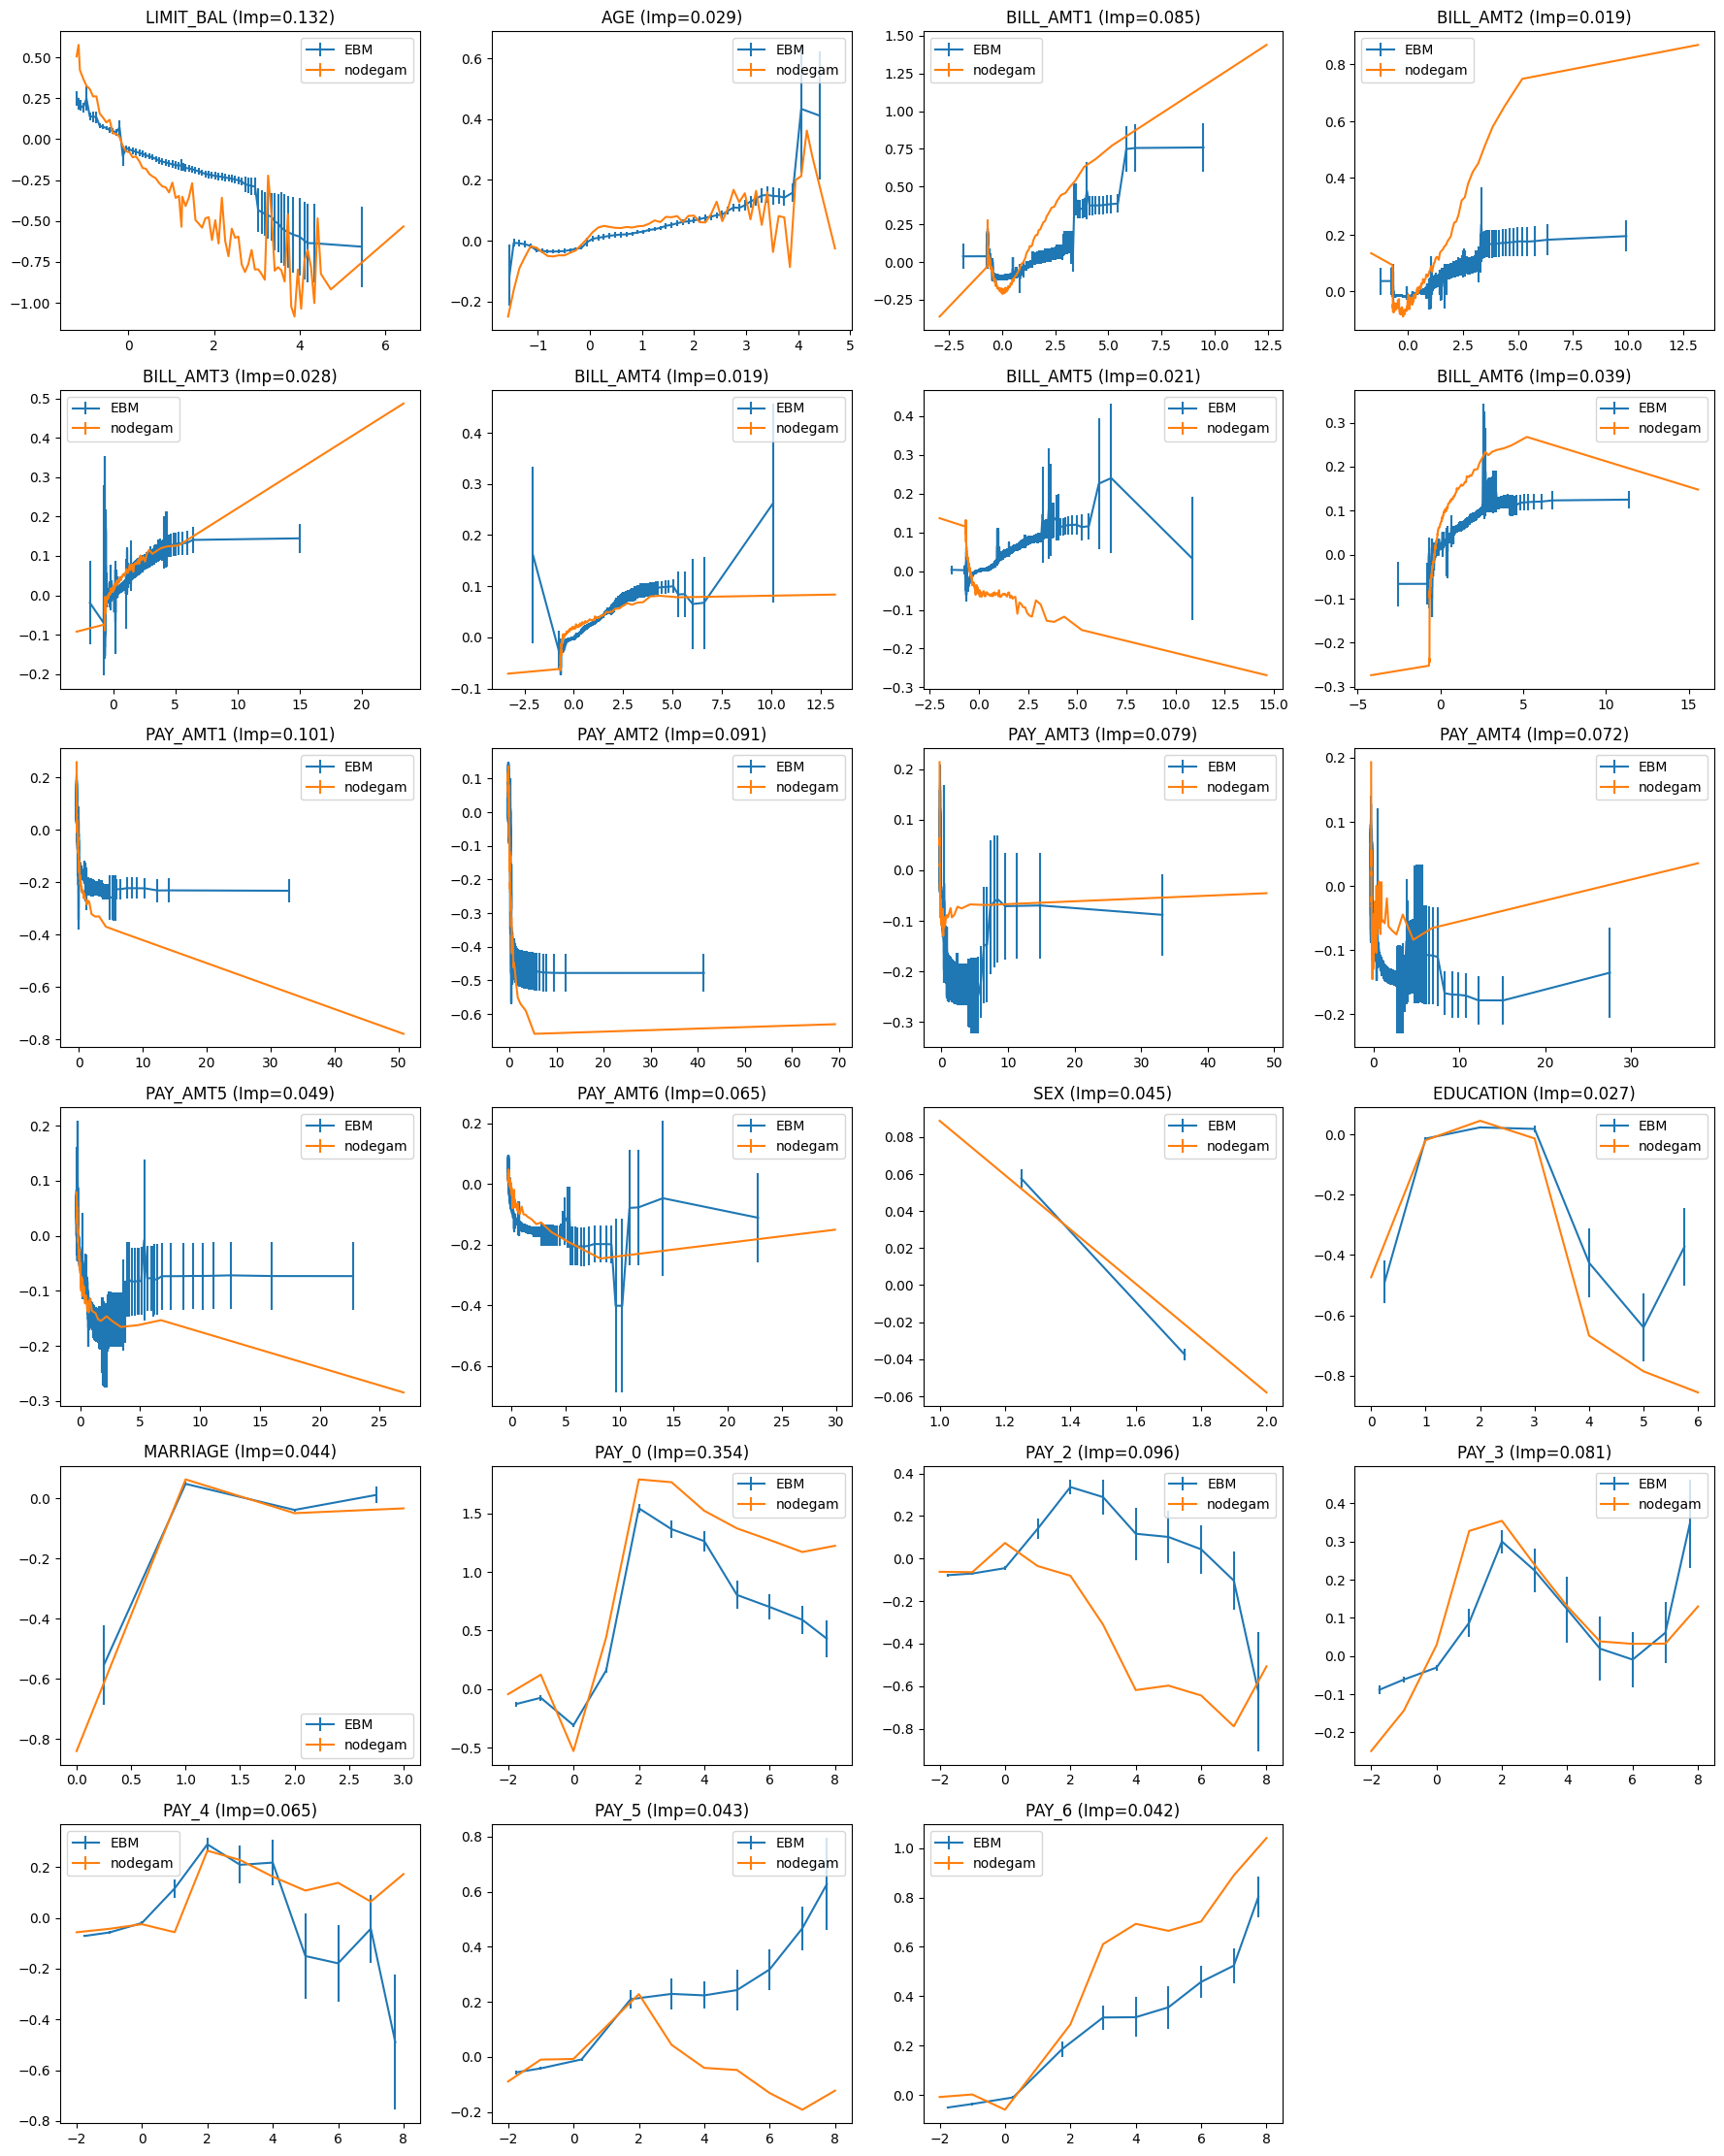

In [ ]:
from nodegam.gams.MyEBM import MyExplainableBoostingClassifier
from nodegam.vis_utils import vis_GAM_effects

# Create and fit the model
ebm = MyExplainableBoostingClassifier(feature_names=all_features)
ebm.fit(X_train_df, y_train_series)


fig, ax = vis_GAM_effects(
    all_dfs={
        'EBM': ebm.get_GAM_df(),
        'nodegam': gam_df,
    },
)


